In [3]:
from TorchClassifierData.ClassifierData import ClassifierImporter,ClassifierDisplayer
from TorchClassifierData.ClassifierData import ClassifierTrainTestSpliter,ClassifierNormalizer

In [4]:
datapath=r"C:\Users\charleslf\Downloads\Compressed\Dataset"

In [5]:
classes=["Bus","Car","motorcycle","Truck"]
vehi_dataset=ClassifierImporter(datapath,classes,size=(50,50))

In [6]:
trainset,testset=ClassifierTrainTestSpliter(vehi_dataset)

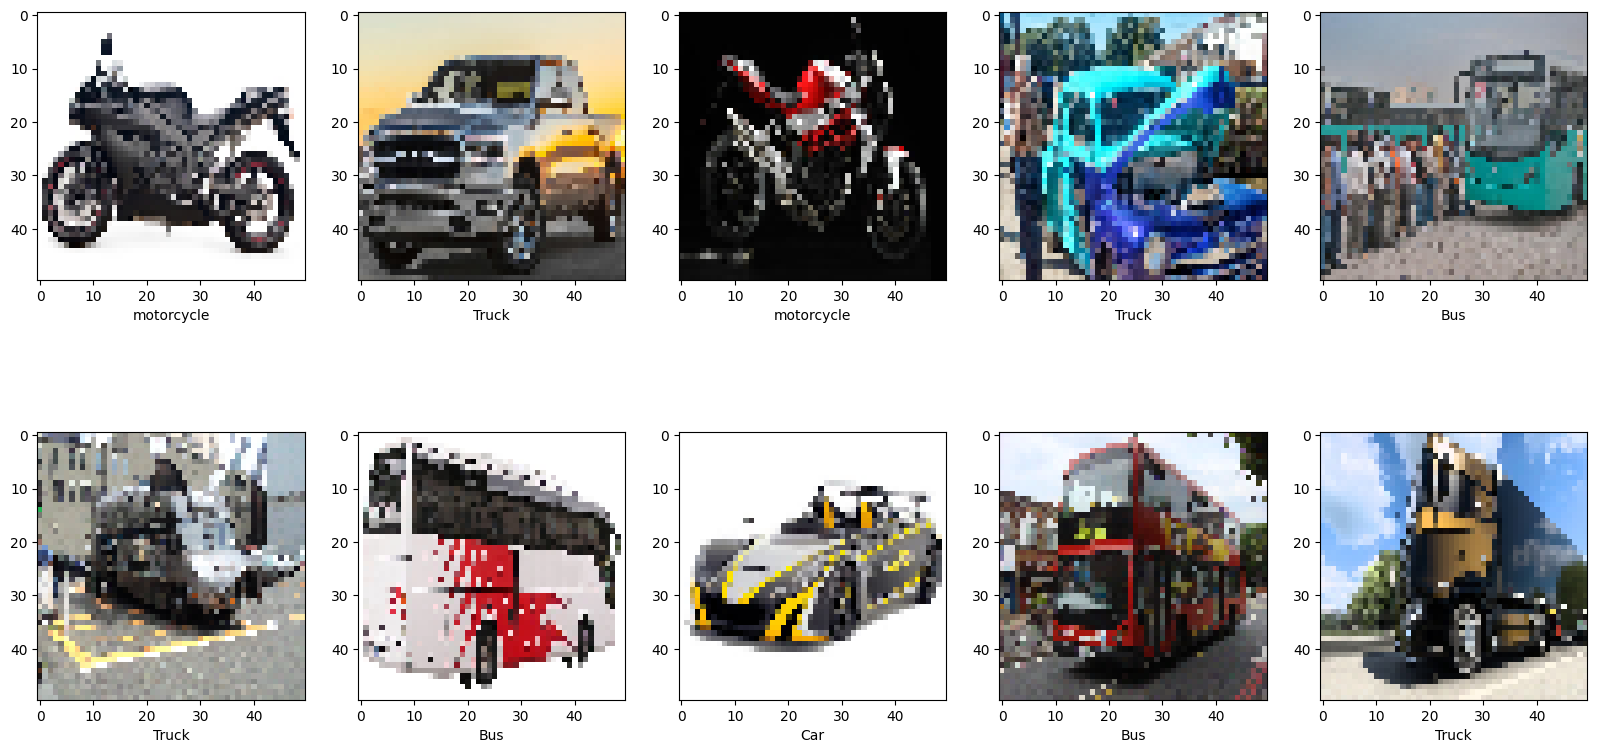

In [7]:
ClassifierDisplayer(trainset,classes,batch=2)

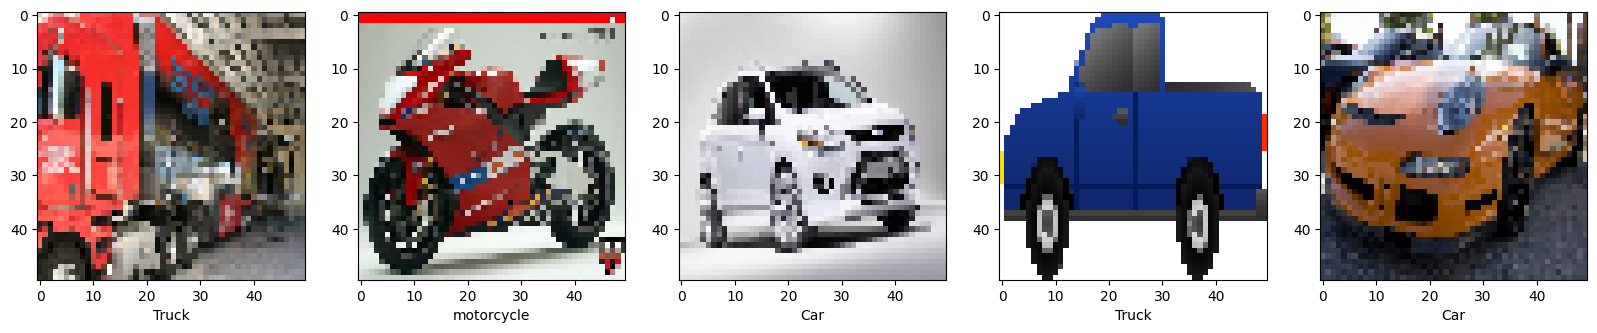

In [8]:
ClassifierDisplayer(testset,classes,batch=1)

In [9]:
norm_trainset=ClassifierNormalizer(trainset)
norm_testset=ClassifierNormalizer(testset)

In [10]:
import torch
batch_size=4
trainloader=torch.utils.data.DataLoader(norm_trainset,batch_size=batch_size,num_workers=2)
testloader=torch.utils.data.DataLoader(norm_testset,batch_size=batch_size,num_workers=2)

In [11]:
import torch.nn as nn
import torch.nn.functional as F
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1=nn.Conv2d(3,6,5)
        self.pool1=nn.MaxPool2d(2,2)
        self.pool2=nn.MaxPool2d(2,2)
        self.conv2=nn.Conv2d(6,16,5)
        self.fc1=nn.Linear(1296,120)
        self.fc2=nn.Linear(120,84)
        self.fc3=nn.Linear(84,10)
    
    def forward(self,x):
        x=self.pool1(F.relu(self.conv1(x)))
        x=self.pool2(F.relu(self.conv2(x)))
        x=torch.flatten(x,1)
        x=F.relu(self.fc1(x))
        x=F.relu(self.fc2(x))
        x=self.fc3(x)
        return x
net=Net()
print(net)
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(net.parameters(),lr=0.0001,momentum=0.9)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=1296, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [12]:
for epoch in range(100):
    print("Epoch {} \n ----------------".format(epoch))
    for i,data in enumerate(trainloader,0):
        inputs,labels=data
        optimizer.zero_grad()
        outputs=net(inputs)
        loss=criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        if i %10==0:
            print("loss:{}".format(loss.item()))
print("Finished Trainning")

Epoch 0 
 ----------------
loss:2.2972536087036133
loss:2.3656764030456543
loss:2.2987313270568848
loss:2.2996363639831543
loss:2.262640953063965
loss:2.35603404045105
loss:2.2462382316589355
loss:2.276423215866089
Epoch 1 
 ----------------
loss:2.2785232067108154
loss:2.3480637073516846
loss:2.27532958984375
loss:2.2773754596710205
loss:2.243764638900757
loss:2.339097499847412
loss:2.2152891159057617
loss:2.2498691082000732
Epoch 2 
 ----------------
loss:2.258455991744995
loss:2.3290634155273438
loss:2.252443552017212
loss:2.255168914794922
loss:2.2246766090393066
loss:2.321640729904175
loss:2.1847617626190186
loss:2.2235097885131836
Epoch 3 
 ----------------
loss:2.237409830093384
loss:2.3093326091766357
loss:2.2288665771484375
loss:2.2325782775878906
loss:2.2044239044189453
loss:2.3030154705047607
loss:2.1535110473632812
loss:2.195505142211914
Epoch 4 
 ----------------
loss:2.2141005992889404
loss:2.287275552749634
loss:2.2027602195739746
loss:2.208092212677002
loss:2.1823611259

In [88]:
# TEST

In [14]:
correct=0
total=0
with torch.no_grad():
    for data in testloader:
        images,labels=data
        outputs=net(images)
        _,predicted=torch.max(outputs.data,1)
        total+=labels.size(0)
        correct+=(predicted==labels).sum().item()
print("accuracy on 80 test images",100*correct//total,"%")

accuracy on 80 test images 26 %


In [15]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1
# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: Bus   is 54.5 %
Accuracy for class: Car   is 39.3 %
Accuracy for class: motorcycle is 13.6 %
Accuracy for class: Truck is 5.3 %
